In [1]:
from typing import Sequence, Tuple
from pprint import pprint
from rltk.core import State, Action, Reward
from rltk.gridworld import GridVisualizer, GridMDP
from rltk.planning import Planning, SqlitePlanningMetricWriter, PlanningMetric
import rltk.metrics as metrics
import sqlite3
import pickle

In [2]:
class FrozenLake(GridMDP):
    def __init__(self, nrows, ncols):
        super().__init__(nrows, ncols)

    def reward(self, state: State, action: Action, next_state: State) -> Reward:
        # reward does not depend on state or action, but only on next_state
        return 1. if self.is_goal(next_state) else 0.

    def dist(self, state: State, action: Action) -> Sequence[Tuple[State, float]]:
        if action == 'up' or action == 'down':
            stochastic_actions = ['left', 'right']
        else:
            stochastic_actions = ['up', 'down']

        s: Cell = self.state2cell(state)
        probs: List[Tuple[State, float]] = []
        s_: Cell = self.next_cell(s, action)
        probs.append((self.cell2state(s_), 0.8))
        for a in stochastic_actions:
            s_ = self.next_cell(s, a)
            probs.append((self.cell2state(s_), 0.1))
        return probs
    
fl = FrozenLake(4, 4)
fl.goals = {(3,3)}
fl.terminals = {(1,1), (1,3), (2,3), (3,0), (3,3)}

In [3]:
writer = SqlitePlanningMetricWriter('/Users/avilay/temp/rltk.db')
metrics.set_writer(writer)

planning = Planning(fl)
svals = planning.policy_iteration()
pprint(svals)

print(f'Metrics saved under run id: {writer.run_id}')
writer.close()

{'(0,0)': 0.3804495149479562,
 '(0,1)': 0.35888774235577464,
 '(0,2)': 0.4535942300409378,
 '(0,3)': 0.35888774235577464,
 '(1,0)': 0.4359849472017947,
 '(1,1)': 0.0,
 '(1,2)': 0.5402700506427809,
 '(1,3)': 0.0,
 '(2,0)': 0.551036530625346,
 '(2,1)': 0.7108303964290363,
 '(2,2)': 0.7503750703508848,
 '(2,3)': 0.0,
 '(3,0)': 0.0,
 '(3,1)': 0.8245879893949177,
 '(3,2)': 0.9533337981649121,
 '(3,3)': 0.0}
Metrics saved under run id: cool-mountain-9603


In [4]:
db = '/Users/avilay/temp/rltk.db'
conn = sqlite3.connect(db)
sql = '''
SELECT run_id, context_id, timestamp, iter_num, svals, qvals, pidist
FROM planning_metrics
WHERE run_id = ?
AND context_id = ?
'''
params = [writer.run_id, 'policy_iteration']
cur = conn.execute(sql, params)

metrics = []
for row in cur:
    run_id = row[0]
    context_id = row[1]
    timestamp = row[2]
    iter_num = row[3]
    svals = pickle.loads(row[4])
    qvals = pickle.loads(row[5])
    pidist = pickle.loads(row[6])
    metric = PlanningMetric(context_id=context_id, iter_num=iter_num, svals=svals, qvals=qvals, pidist=pidist)
    metrics.append(metric)

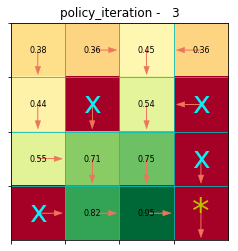

In [7]:
visualizer = GridVisualizer(fl)
visualizer.visualize(metrics, sleep_secs=3)